# Whole Slide Image Classification Using PyTorch and TIAToolbox


## Introduction

In this tutorial, we will show you how you can classify Whole Slide Images (WSIs) using PyTorch deep learning models with help from TIAToolbox. In a nutshell, WSIs represent human tissues taken through a biopsy and scanned using specialized scanners. They are used by pathologists and computational pathology researchers to [study cancer at the microscopic level](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7522141/) in order to understand tumor growth and help improve treatment for patients.

Now, the trick with WSIs is their enormous size. For example, a typical slide image has in the order of [100,000x100,000 pixels](https://doi.org/10.1117%2F12.912388) where each pixel can correspond to about 0.25 microns (if using 40X magnification). This introduces challenges in loading and processing such images, not to mention hundreds of them in a single study! 

So how can you import WSIs that are in the size of gigabytes each and run algorithms on them to analyze their visual features? Conventional image processing pipelines will not be suitable and hence we need more optimized tools of the trade. This where [TIAToolbox](https://github.com/TissueImageAnalytics/tiatoolbox) comes into play, as it brings a set of useful tools to import and process tissue slides in a fast and computationally efficient manner by taking advantage of its pyramid structure to downsample the image at set zoom levels. Here is how the pyramid structure looks like:

![WSI pyramid stack](../_static/img/read_bounds_tissue.webp)
*WSI pyramid stack ([source](https://tia-toolbox.readthedocs.io/en/latest/_autosummary/tiatoolbox.wsicore.wsireader.WSIReader.html#))*

<br/>

The toolbox also allows you to automate common downstream analysis tasks such as [tissue classification](https://doi.org/10.1016/j.media.2022.102685). So, in this tutorial we will show you how you can:
1. Load WSI images using TIAToolbox; and
2. Use different PyTorch models to classify slides at the batch-level (i.e., small tiles).

So, let's get started!


## Setting up the environment

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [7]:
%%bash
apt-get -y -qq install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev 
pip install -q tiatoolbox && echo "Installation is done."

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Installation is done.


**IMPORTANT**: If you are running this notebook on Colab, then, after running the above cell for the first time, you need to restart the runtime in order to use the latest version of the packages used by TIAToolbox. To do this, you can click on the "RESTART RUNTIME" message that appears at the bottom of the cell, or use the menu *Runtime→Restart runtime*. Subsequently, you can use *Runtime→Run all*, **OR** *Runtime→Run after* **OR** run the cells one by one, as you prefer.



### Importing related libraries



In [4]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging
import warnings

import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn.metrics import accuracy_score, confusion_matrix

from tiatoolbox import logger
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

# Configure logging
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

# If you are not using GPU, change ON_GPU to False
ON_GPU = True

### Clean-up before a run

To ensure proper clean-up (for example in abnormal termination), all files downloaded or created in this run are saved in a single directory `global_save_dir`, which we set equal to "./tmp/". To simplify maintenance, the name of the directory occurs only at this one place, so that it can easily be changed, if desired.



In [2]:
warnings.filterwarnings("ignore")
global_save_dir = Path("./tmp/")


def rmdir(dir_path: str | Path) -> None:
    """Helper function to delete directory."""
    if Path(dir_path).is_dir():
        shutil.rmtree(dir_path)
        logger.info("Removing directory %s", dir_path)


rmdir(global_save_dir)  # remove  directory if it exists from previous runs
global_save_dir.mkdir()
logger.info("Creating new directory %s", global_save_dir)

|2023-11-10|23:58:06.705| [INFO] Removing directory tmp
|2023-11-10|23:58:06.706| [INFO] Creating new directory tmp


### Downloading the data
For our sample data, we will use one image tile and one whole-slide image from the validation subset of [Kather 100k](https://zenodo.org/record/1214456#.YJ-tn3mSkuU) dataset.


In [3]:
img_file_name = global_save_dir / "sample_tile.png"
wsi_file_name = global_save_dir / "sample_wsi.svs"
patches_file_name = global_save_dir / "kather100k-validation-sample.zip"
imagenet_samples_name = global_save_dir / "imagenet_samples.zip"

logger.info("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif",
    img_file_name,
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_file_name,
)

# Download a sample of the validation set used to train the Kather 100K dataset
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_file_name,
)
# Unzip it!
with ZipFile(patches_file_name, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

# Download some samples of imagenet to test the external models
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip",
    imagenet_samples_name,
)
# Unzip it!

with ZipFile(imagenet_samples_name, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

logger.info("Download is complete.")

|2023-11-10|23:58:06.712| [INFO] Download has started. Please wait...
|2023-11-10|23:58:22.788| [INFO] Download is complete.


## Reading the data

We create a list of patches and a list of corresponding labels.
For example, the first label in `label_list` will indicate the class of the first image patch in `patch_list`.



|2023-11-10|23:58:22.815| [INFO] Class ID: 0 -- Class Name: BACK -- Number of images: 211
|2023-11-10|23:58:22.816| [INFO] Class ID: 1 -- Class Name: NORM -- Number of images: 176
|2023-11-10|23:58:22.816| [INFO] Class ID: 2 -- Class Name: DEB -- Number of images: 230
|2023-11-10|23:58:22.816| [INFO] Class ID: 3 -- Class Name: TUM -- Number of images: 286
|2023-11-10|23:58:22.816| [INFO] Class ID: 4 -- Class Name: ADI -- Number of images: 208
|2023-11-10|23:58:22.817| [INFO] Class ID: 5 -- Class Name: MUC -- Number of images: 178
|2023-11-10|23:58:22.817| [INFO] Class ID: 6 -- Class Name: MUS -- Number of images: 270
|2023-11-10|23:58:22.817| [INFO] Class ID: 7 -- Class Name: STR -- Number of images: 209
|2023-11-10|23:58:22.817| [INFO] Class ID: 8 -- Class Name: LYM -- Number of images: 232
|2023-11-10|23:58:22.818| [INFO] Total number of patches: 2000


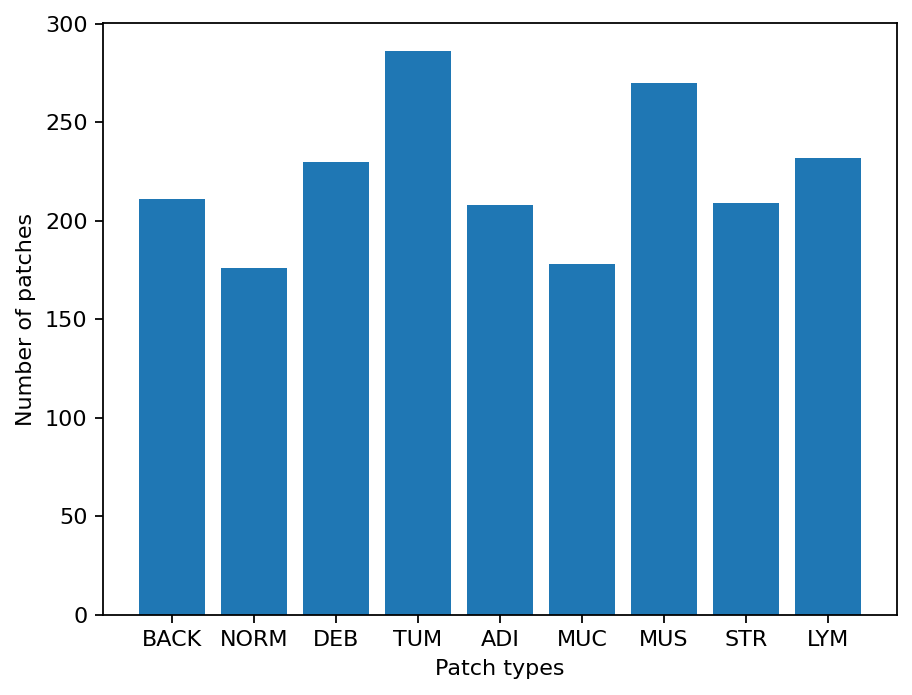

In [4]:
# read the patch data and create a list of patches and a list of corresponding labels

dataset_path = global_save_dir / "kather100k-validation-sample"

# set the path to the dataset
image_ext = ".tif"  # file extension of each image

# obtain the mapping between the label ID and the class name
label_dict = {
    "BACK": 0,
    "NORM": 1,
    "DEB": 2,
    "TUM": 3,
    "ADI": 4,
    "MUC": 5,
    "MUS": 6,
    "STR": 7,
    "LYM": 8,
}
class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = dataset_path / class_name
    patch_list_single_class = grab_files_from_dir(
        dataset_class_path,
        file_types="*" + image_ext,
    )
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))


# show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

# count the number of examples per class
for class_name, label in label_dict.items():
    logger.info(
        "Class ID: %d -- Class Name: %s -- Number of images: %d",
        label,
        class_name,
        label_list.count(label),
    )


# overall dataset statistics
logger.info("Total number of patches: %d", (len(patch_list)))

As you can see for this patch dataset, we have 9 classes/labels with IDs 0-8 and associated class names. describing the dominant tissue type in the patch:

- BACK ⟶ Background (empty glass region)
- LYM  ⟶ Lymphocytes
- NORM ⟶ Normal colon mucosa
- DEB  ⟶ Debris
- MUS  ⟶ Smooth muscle
- STR  ⟶ Cancer-associated stroma
- ADI  ⟶ Adipose
- MUC  ⟶ Mucus
- TUM  ⟶ Colorectal adenocarcinoma epithelium



## Predict patch labels 

We create a predictor object and then call the `predict` method.



In [5]:
predictor = PatchPredictor(pretrained_model="resnet18-kather100k", batch_size=32)
output = predictor.predict(imgs=patch_list, mode="patch", on_gpu=ON_GPU)

100%|###########################################| 63/63 [00:02<00:00, 22.15it/s]



The PatchPredictor class defines a CNN-based classifier. 

- `pretrained_model` argument specifies the CNN model that performs the prediction, and it must be one of the models listed [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=pretrained%20models#tiatoolbox.models.architecture.get_pretrained_model). To use your own PyTorch model, pass it as the `model` argument.
- `model` can be any trained PyTorch model with the constraint that the it should follow the `tiatoolbox.models.abc.ModelABC` class structure. For more information on this matter, please refer to [example notebook on advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07-advanced-modeling.ipynb).

- `pretrained_weight`: When using a `pretrained_model`, the corresponding pretrained weights will also be downloaded by default.  You can override the default with your own set of weights via the `pretrained_weight` argument.
- `batch_size`: Number of images fed into the model each time. Higher values for this parameter require a larger (GPU) memory capacity.


The `predict` method applies the CNN on the input patches and get the results. Here are the arguments and their descriptions:

- `mode`: Type of input to be processed. Choose from `patch`, `tile` or `wsi` according to your application. In this first example, we predict the tissue type of histology patches, so we use the `patch` option. The use of `tile` and `wsi` options are explained below.
- `imgs`: List of inputs. When using `patch` mode, the input must be a list of images OR a list of image file paths, OR a Numpy array corresponding to an image list. However, for the `tile` and `wsi` modes, the `imgs` argument should be a list of paths to the input tiles or WSIs.
- `return_probabilities`: set to *__True__* to get per class probabilities alongside predicted labels of input patches. If you wish to merge the predictions to generate prediction maps for `tile` or `wsi` modes, you can set `return_probabilities=True`.

In the `patch` prediction mode, the `predict` method returns an output dictionary that contains the `predictions` (predicted labels) and `probabilities` (probability that a certain patch belongs to a  certain class).

 



## Evaluate the prediction

We compute the classification accuracy and confusion matrix.

In [6]:
acc = accuracy_score(label_list, output["predictions"])
logger.info("Classification accuracy: %f", acc)

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output["predictions"], normalize="true")
df_cm = pd.DataFrame(conf, index=class_names, columns=class_names)

# show confusion matrix
# sns.heatmap(df_cm, cmap="Blues", annot=True, fmt=".0%")
# plt.show()

|2023-11-10|23:58:26.147| [INFO] Classification accuracy: 0.993000


Try changing the `pretrained_model` argument when making `PatchPredictor` instant and see how it can affect the classification output accuracy.



## Get predictions for patches within a WSI

We demonstrate how to obtain predictions for all patches within a whole-slide image. As in previous sections, we will use `PatchPredictor` and its `predict` method, but this time we set the `mode` to `'wsi'`. We also introduce `IOPatchPredictorConfig`, a class that specifies the configuration of image reading and prediction writing for the model prediction engine.



In [7]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

Parameters of `IOPatchPredictorConfig` are defined as:

- `input_resolutions`: a list specifying the resolution of each input head of model in the form of a dictionary. List elements must be in the same order as target `model.forward()`. If your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. Note that TIAToolbox supports a model with more than one input.
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `stride_shape`: the size of stride (steps) between two consecutive patches, used in the patch extraction process. If the user sets `stride_shape` equal to `patch_input_shape`, patches will be extracted and processed without any overlap.

Since we are using a large WSI the patch extraction and prediction processes may take some time (make sure to set the `ON_GPU=True` if you have access to Cuda enabled GPU and Pytorch+Cuda).



In [8]:
predictor = PatchPredictor(pretrained_model="resnet18-kather100k", batch_size=64)
wsi_output = predictor.predict(
    imgs=[wsi_file_name],
    masks=None,
    mode="wsi",
    merge_predictions=False,
    ioconfig=wsi_ioconfig,
    return_probabilities=True,
    save_dir=global_save_dir / "wsi_predictions",
    on_gpu=ON_GPU,
)

|2023-11-10|23:58:26.294| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


100%|#########################################| 315/315 [02:04<00:00,  2.53it/s]


We introduce some new arguments for `predict` method:

- `mode`: set to 'wsi' when analysing whole slide images.
- `ioconfig`: set the IO configuration information using the `IOPatchPredictorConfig` class.
- `resolution` and `unit` (not shown above): These arguments specify the level or micron-per-pixel resolution of the WSI levels from which we plan to extract patches and can be used instead of `ioconfig`. Here we specify the WSI's level as `'baseline'`, which is equivalent to level 0. In general, this is the level of greatest resolution. In this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect).
- `masks`: A list of paths corresponding to the masks of WSIs in the     `imgs` list. These masks specify the regions in the original WSIs from which we want to extract patches. If the mask of a particular WSI is specified as `None`, then the labels for all patches of that WSI (even background regions)  would be predicted. This could cause unnecessary computation.
- `merge_predictions`: You can set this parameter to `True` if you wish to generate a 2D map of patch classification results. However, for big WSIs you might need a large amount of memory available to do this on the file. An alternative (default) solution is to set `merge_predictions=False`, and then generate the 2D prediction maps using `merge_predictions` function as you will see later on.


We see how the prediction model works on our whole-slide images by visualizing the `wsi_output`. We first need to merge patch prediction outputs and then visualize them as an overlay on the original image. As before, the `merge_predictions` method is used to merge the patch predictions. Here we set the parameters `resolution=1.25, units='power'` to generate the prediction map at 1.25x magnification. If you would like to have higher/lower resolution (bigger/smaller) prediction maps, you need to change these parameters accordingly. When the predictions are merged, use the `overlay_patch_prediction` function to overlay the prediction map on the WSI thumbnail, which should be extracted at the same resolution used for prediction merging. 



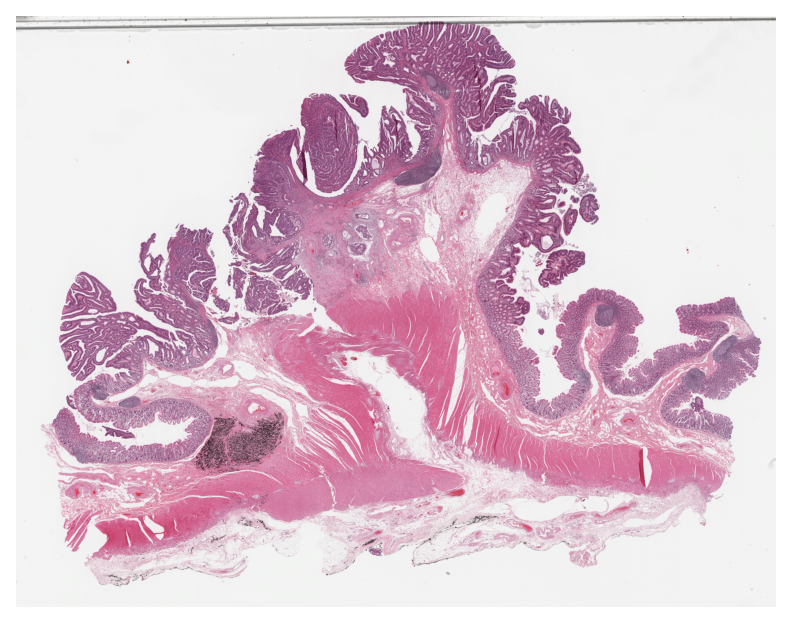

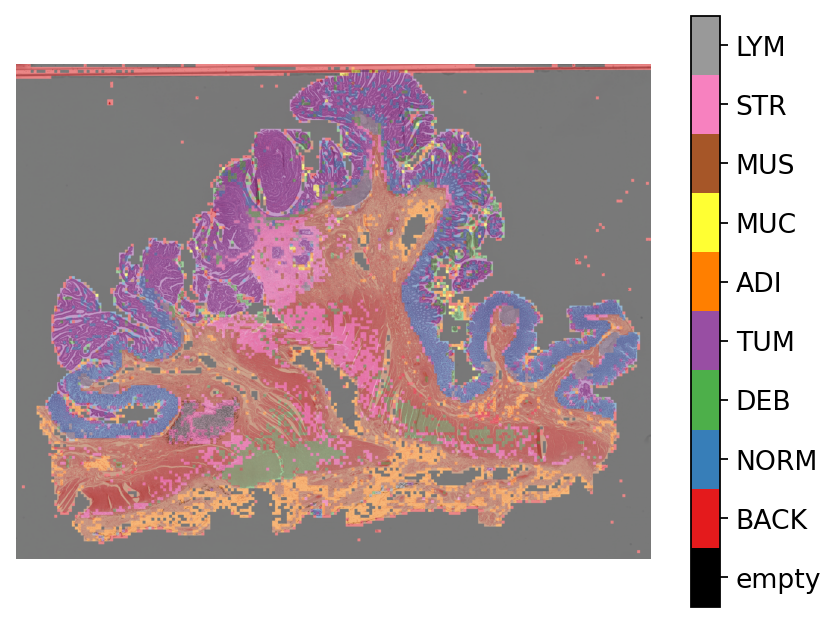

In [9]:
# visualization of whole-slide image patch-level prediction
# first set up a label to color mapping
label_color_dict = {}
label_color_dict[0] = ("empty", (0, 0, 0))
colors = cm.get_cmap("Set1").colors
for class_name, label in label_dict.items():
    label_color_dict[label + 1] = (class_name, 255 * np.array(colors[label]))
overview_resolution = (
    4  # the resolution in which we desire to merge and visualize the patch predictions
)

# the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
overview_unit = "mpp"
wsi = WSIReader.open(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")

pred_map = predictor.merge_predictions(
    wsi_file_name,
    wsi_output[0],
    resolution=overview_resolution,
    units=overview_unit,
)
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)
plt.show()

## Feature extraction with a cpath-specific model

In this section, we will show how to extract features from a pretrained pytorch model that exists outside tiatoolbox, using the WSI inference engines provided by tiatoolbox. To illustrate this we will be using HistoEncoder, a computational-pathology specific model that has been trained in a self-supervised fashion to extract features from histology images. The model has been made available here:

'HistoEncoder: Foundation models for digital pathology' (https://github.com/jopo666/HistoEncoder) by Pohjonen, Joona and team at the University of Helsinki. The model can be installed via `pip install histoencoder`.

We will plot a umap reduction into 3D (rgb) of the featue map to visualize how the features capture the differences between some of the above mentioned tissue types.

In [10]:
# import some things we will need
import histoencoder.functional as F
import torch.nn as nn
import torch
import torchvision.transforms as transforms

from tiatoolbox.models.engine.semantic_segmentor import DeepFeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.models_abc import ModelABC
import umap

TIAToolbox defines a ModelABC which specifies how a model should look in order to be used in the tiatoolbox inference engines. The histoencoder model doesn't follow this structure, so we will need to wrap it in a class that does so that it's output and methods are as the tiatoolbox engine expects.

In [11]:
class HistoEncWrapper(ModelABC):
    """Wrapper for HistoEnc model that conforms to tiatoolbox ModelABC interface."""

    def __init__(self: HistoEncWrapper, encoder) -> None:
        super().__init__()
        self.feat_extract = encoder

    def forward(self: HistoEncWrapper, imgs: torch.Tensor) -> torch.Tensor:
        """Pass input data through the model.

        Args:
            imgs (torch.Tensor):
                Model input.

        """
        out = F.extract_features(self.feat_extract, imgs, num_blocks=2, avg_pool=True)
        return out

    @staticmethod
    def infer_batch(
        model: nn.Module,
        batch_data: torch.Tensor,
        *,
        on_gpu: bool,
    ) -> list[np.ndarray]:
        """Run inference on an input batch.

        Contains logic for forward operation as well as i/o aggregation.

        Args:
            model (nn.Module):
                PyTorch defined model.
            batch_data (torch.Tensor):
                A batch of data generated by
                `torch.utils.data.DataLoader`.
            on_gpu (bool):
                Whether to run inference on a GPU.

        """
        img_patches_device = batch_data.to('cuda') if on_gpu else batch_data
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            output = model(img_patches_device)
        return [output.cpu().numpy()]

Now that we have our wrapper, we will create our feature extraction model and instantiate a DeepFeatureExtractor to allow us to use this model over a WSI. We will use the same WSI as above, but this time we will extract features from the patches of the WSI using the HistoEncoder model, rather than predicting some label for each patch.

In [12]:
encoder = F.create_encoder("prostate_medium")

model = HistoEncWrapper(encoder)

# set the pre-processing function
norm=transforms.Normalize(mean=[0.662, 0.446, 0.605],std=[0.169, 0.190, 0.155])
trans = [
    transforms.ToTensor(),
    norm,
]
model.preproc_func = transforms.Compose(trans)

In [13]:

wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    output_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_output_shape=[224, 224],
    stride_shape=[224, 224],
)

extractor = DeepFeatureExtractor(model=model, auto_generate_mask=True, batch_size=32, num_loader_workers=4, num_postproc_workers=4)
out = extractor.predict(imgs=[wsi_file_name], mode="wsi", ioconfig=wsi_ioconfig, save_dir=global_save_dir / "wsi_features",)

|2023-11-11|00:01:01.151| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
Process Batch: 100%|##########################| 630/630 [01:17<00:00,  8.13it/s]


|2023-11-11|00:02:19.321| [INFO] Finish: 0
|2023-11-11|00:02:19.322| [INFO] --Input: tmp/sample_wsi.svs
|2023-11-11|00:02:19.322| [INFO] --Output: /home/u2071810/Code/tutorials/intermediate_source/tmp/wsi_features/0


These features could be used to train a downstream model, but here in order to get some intuition for what the features represent, we will use a UMAP reduction to visualize the features in RGB space. Similarly colored points should have similar features, so we can see if the features naturally separate out into the different tissue regions when we overlay the UMAP reduction on the WSI thumbnail. We will plot it along with the patch-level prediction map from above to see how the features compare to the patch-level predictions in the following cells.

In [14]:
# first we will define a function to calculate the umap reduction
def umap_reducer(x, dims=3, nns=10):
    """UMAP reduction of the input data."""
    reducer = umap.UMAP(n_neighbors=nns, n_components=dims, metric="manhattan", spread=0.5)
    reduced = reducer.fit_transform(x)
    reduced -= reduced.min(axis=0)
    reduced /= reduced.max(axis=0)
    return reduced

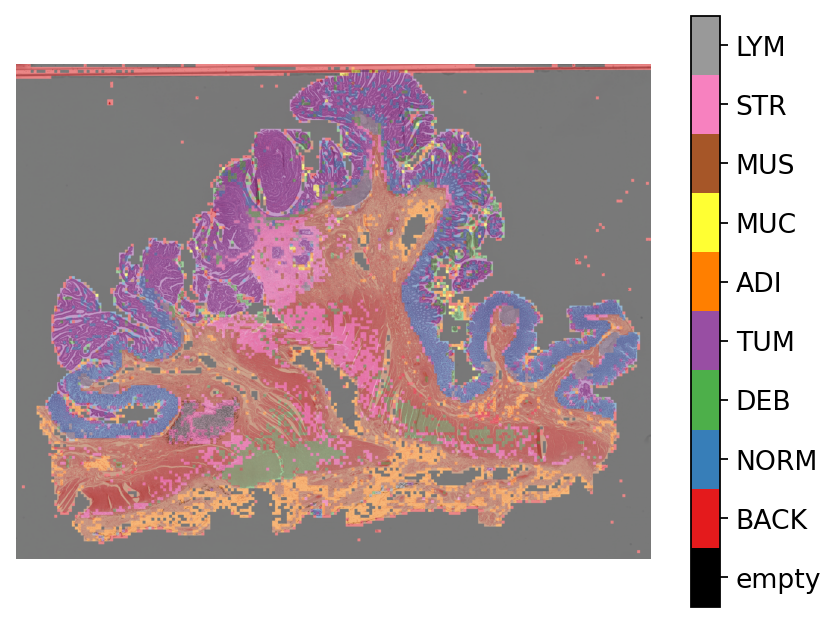

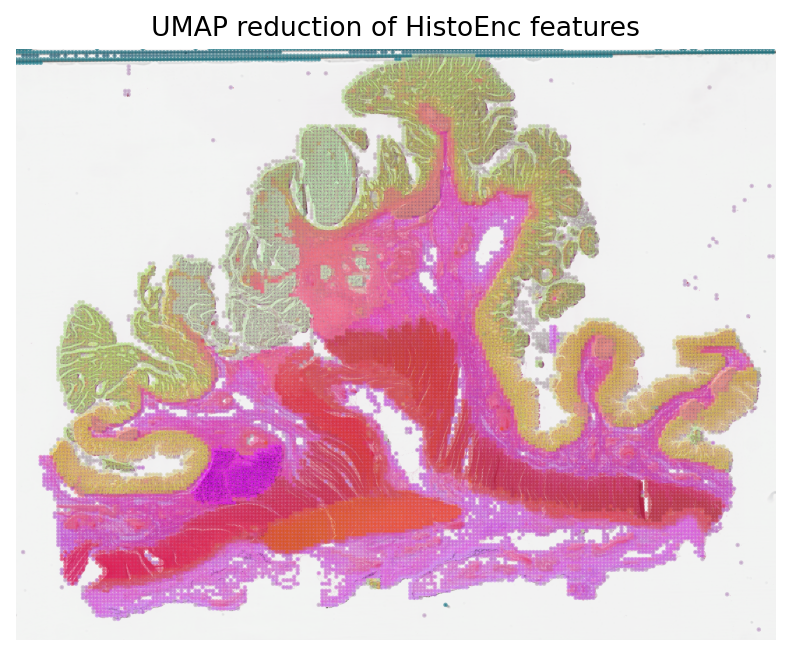

In [15]:
# load the features output by our feature extractor
pos = np.load(global_save_dir / "wsi_features" / "0.position.npy")
feats = np.load(global_save_dir / "wsi_features" / "0.features.0.npy")
pos = pos / 8 # as we extracted at 0.5mpp, and we are overlaying on a thumbnail at 4mpp

reduced = umap_reducer(feats)

# reduce the features to 3 dimensions and plot them
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)
plt.figure()
plt.imshow(wsi_overview)
plt.scatter(pos[:,0], pos[:,1], c=reduced, s=1, alpha=0.5)
plt.axis("off")
plt.title("UMAP reduction of HistoEnc features")
plt.show()

We can clearly see that the prediction map from our patch-level predictor, and the feature map from our self-supervised feature encoder, capture similar information about the tissue types in the WSI. This is a good sanity check that our models are working as expected. It also shows that the features extracted by the HistoEncoder model are capturing the differences between the tissue types, and thus that they are encoding histologically relevant information.

In this notebook, we show how we can use the `PatchPredictor` and `DeepFeatureExtractor` classes and their `predict` method to predict the label, or extract features, for patches of big tiles and WSIs. We introduce `merge_predictions` and `overlay_prediction_mask` helper functions that merge the patch prediction outputs and visualize the resulting prediction map as an overlay on the input image/WSI.

All the processes take place within TIAToolbox and you can easily put the pieces together, following our example code. Just make sure to set inputs and options correctly. We encourage you to further investigate the effect on the prediction output of changing `predict` function parameters. Furthermore, we showed how to use your own pretrained model (or one provided by the research community for a specific task) in the TIAToolbox framework to do inference on large WSIs (even if the model structure is not defined in the TIAToolbox model class).

